In [10]:
import pytest
import torch

import triton
import triton.language as tl

In [11]:
@triton.jit
def _attn_fwd_inner(
    acc, l_i, m_i, q,
    K_block_ptr, V_block_ptr,
    start_m, qk_scale,
    BLOCK_M: tl.constexpr,
    BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
    STAGE: tl.constexpr,
    offs_m: tl.constexpr,
    offs_n: tl.constexpr,
):
    # range of values handled by this stage
    if STAGE == 1:
        lo, hi = 0, start_m * BLOCK_M
    else:
        lo, hi = start_m * BLOCK_M, (start_m + 1) * BLOCK_M
        lo = tl.multiple_of(lo, BLOCK_M)
    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))
    # loop over k, v and update accumulator
    for start_n in range(lo, hi, BLOCK_N):
        start_n = tl.multiple_of(start_n, BLOCK_N)
        # -- compute qk ----
        k = tl.load(K_block_ptr)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k)
        if STAGE == 2:
            mask = offs_m[:, None] >= (start_n + offs_n[None, :])
            qk = qk * qk_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(qk, 1))
            qk -= m_ij[:, None]
        else:
            m_ij = tl.maximum(m_i, tl.max(qk, 1) * qk_scale)
            qk = qk * qk_scale - m_ij[:, None]
        p = tl.math.exp2(qk)
        l_ij = tl.sum(p, 1)
        # -- update m_i and l_i
        alpha = tl.math.exp2(m_i - m_ij)
        l_i = l_i * alpha + l_ij
        # -- update output accumulator --
        acc = acc * alpha[:, None]
        # update acc
        v = tl.load(V_block_ptr)
        acc += tl.dot(p.to(tl.float16), v)
        # update m_i and l_i
        m_i = m_ij
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_N, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_N))
    return acc, l_i, m_i

In [12]:
@triton.jit
def _attn_fwd(
    Q, K, V, sm_scale, M, Out,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vk, stride_vn,
    stride_oz, stride_oh, stride_om, stride_on,
    Z, H,
    N_CTX: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
    STAGE: tl.constexpr,
):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    off_z = off_hz // H
    off_h = off_hz % H
    qvk_offset = off_z.to(tl.int64) * stride_qz + off_h.to(tl.int64) * stride_qh

    # block pointers
    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_qm, stride_qk),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0),
    )
    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_vk, stride_vn),
        offsets=(0, 0),
        block_shape=(BLOCK_N, BLOCK_DMODEL),
        order=(1, 0),
    )
    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(BLOCK_DMODEL, N_CTX),
        strides=(stride_kk, stride_kn),
        offsets=(0, 0),
        block_shape=(BLOCK_DMODEL, BLOCK_N),
        order=(0, 1),
    )
    O_block_ptr = tl.make_block_ptr(
        base=Out + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_om, stride_on),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0),
    )
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    # initialize pointer to m and l
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32) + 1.0
    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
    # load scales
    qk_scale = sm_scale
    qk_scale *= 1.44269504  # 1/log(2)
    # load q: it will stay in SRAM throughout
    q = tl.load(Q_block_ptr)
    # stage 1: off-band
    if STAGE & 1:
        acc, l_i, m_i = _attn_fwd_inner(
            acc, l_i, m_i, q, K_block_ptr, V_block_ptr,
            start_m, qk_scale,
            BLOCK_M, BLOCK_DMODEL, BLOCK_N,
            1, offs_m, offs_n,
        )
    # barrier makes it easier for compielr to schedule the
    # two loops independently
    tl.debug_barrier()
    # stage 2: on-band
    if STAGE & 2:
        acc, l_i, m_i = _attn_fwd_inner(
            acc, l_i, m_i, q, K_block_ptr, V_block_ptr,
            start_m, qk_scale,
            BLOCK_M, BLOCK_DMODEL, BLOCK_N,
            2, offs_m, offs_n,
        )
    # epilogue
    m_i += tl.math.log2(l_i)
    acc = acc / l_i[:, None]
    m_ptrs = M + off_hz * N_CTX + offs_m
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, acc.to(Out.type.element_ty))

In [13]:
empty = torch.empty(128, device="cuda")

In [14]:
class _attention(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, v, causal, sm_scale):
        # shape constraints
        Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
        assert Lq == Lk and Lk == Lv
        assert Lk in {16, 32, 64, 128}
        o = torch.empty_like(q)
        BLOCK_M = 128
        BLOCK_N = 64 if Lk <= 64 else 32
        num_stages = 4 if Lk <= 64 else 3
        num_warps = 4
        # Tuning for H100
        if torch.cuda.get_device_capability()[0] == 9:
            num_warps = 8
            num_stages = 7 if Lk >= 64 else 3
        grid = (triton.cdiv(q.shape[2], BLOCK_M), q.shape[0] * q.shape[1], 1)
        M = torch.empty((q.shape[0], q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        _attn_fwd[grid](
            q, k, v, sm_scale, M, o,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            q.shape[0], q.shape[1],
            N_CTX=q.shape[2],
            BLOCK_M=BLOCK_M,
            BLOCK_N=BLOCK_N,
            BLOCK_DMODEL=Lk,
            STAGE=3,
            num_warps=num_warps,
            num_stages=num_stages,
        )

        ctx.save_for_backward(q, k, v, o, M)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.BLOCK_DMODEL = Lk
        ctx.causal = causal
        return o

In [15]:
attention = _attention.apply

In [16]:
try:
    # flash attention的标准使用接口
    from flash_attn_interface import flash_attn_qkvpacked_func as flash_attn_func
    HAS_FLASH = True
except BaseException:
    HAS_FLASH = False

fused-attention-batch4-head48-d64-fwd:
     N_CTX      Triton     Flash-2
0   1024.0  102.926799  104.643679
1   2048.0  157.015831  152.172507
2   4096.0  177.100186  170.051600
3   8192.0  188.602945  179.159634
4  16384.0  195.753735  183.096996


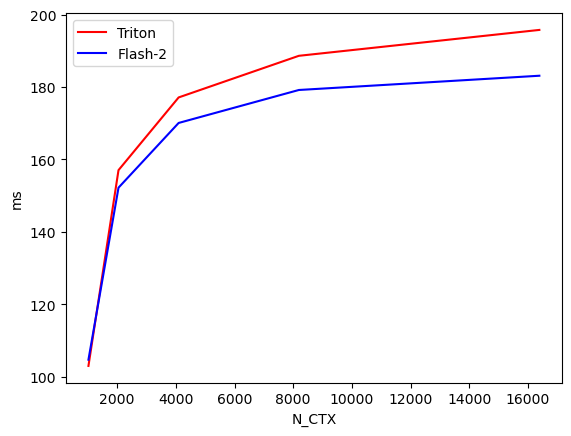

In [18]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 48, 4096, 64
# vary seq length for fixed head and batch=4
configs = [
    triton.testing.Benchmark(
        x_names=["N_CTX"],
        x_vals=[2**i for i in range(10, 15)],
        line_arg="provider",
        line_vals=["triton"] + (["flash"] if HAS_FLASH else []),
        line_names=["Triton"] + (["Flash-2"] if HAS_FLASH else []),
        styles=[("red", "-"), ("blue", "-")],
        ylabel="ms",
        plot_name=f"fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}-{mode}",
        args={
            "H": N_HEADS,
            "BATCH": BATCH,
            "D_HEAD": D_HEAD,
            "dtype": torch.float16,
            "mode": mode,
            "causal": causal,
        },
    )
    for mode in ["fwd"]
    for causal in [True]
]


@triton.testing.perf_report(configs)
def bench_flash_attention(
    BATCH, H, N_CTX, D_HEAD, causal, mode, provider, dtype=torch.float16, device="cuda"
):
    assert mode in ["fwd"]
    warmup = 25
    rep = 100
    if provider == "triton":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        if mode == "fwd":
            q = q.to(torch.float8_e5m2)
            k = k.to(torch.float8_e5m2)
        v = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        sm_scale = 1.3
        fn = lambda: attention(q, k, v, causal, sm_scale)
        if mode == "bwd":
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    if provider == "flash":
        qkv = torch.randn(
            (BATCH, N_CTX, 3, H, D_HEAD), dtype=dtype, device=device, requires_grad=True
        )
        fn = lambda: flash_attn_func(qkv, causal=causal)
        if mode == "bwd":
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    flops_per_matmul = 2.0 * BATCH * H * N_CTX * N_CTX * D_HEAD
    total_flops = 2 * flops_per_matmul
    if causal:
        total_flops *= 0.5
    if mode == "bwd":
        total_flops *= 2.5  # 2.0(bwd) + 0.5(recompute)
    return total_flops / ms * 1e-9


# only works on post-Ampere GPUs right now
bench_flash_attention.run(save_path=".", print_data=True)